In [1]:

# --- PyCaret compatibility guard (Python 3.9/3.10/3.11) with sklearn fallback for Python 3.12+ ---
import sys, warnings

PYTHON_OK = sys.version_info[:2] in [(3,9),(3,10),(3,11)]
USE_PYCARET = PYTHON_OK

if USE_PYCARET:
    try:
        # Import your usual PyCaret APIs here (add regression/classification as needed)
        from pycaret.utils import version as pycaret_version
        print("PyCaret available. Version:", pycaret_version())
    except Exception as e:
        warnings.warn(f"PyCaret import failed: {e}. Falling back to scikit-learn.")
        USE_PYCARET = False

if not USE_PYCARET:
    warnings.warn(f"PyCaret is not supported on Python {sys.version_info.major}.{sys.version_info.minor}. "
                  "Using a lightweight scikit-learn fallback for common tasks.")
    # --- Minimal sklearn fallbacks you can call when PyCaret is unavailable ---
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error
    from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

    def pycaret_like_classification(df, target, test_size=0.2, random_state=42):
        X = df.drop(columns=[target])
        y = df[target]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y if len(set(y))>1 else None
        )
        model = RandomForestClassifier(random_state=random_state)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"[Fallback sklearn] Accuracy: {acc:.3f}")
        return model, {"accuracy": acc}

    def pycaret_like_regression(df, target, test_size=0.2, random_state=42):
        X = df.drop(columns=[target])
        y = df[target]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        model = RandomForestRegressor(random_state=random_state)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        print(f"[Fallback sklearn] R2: {r2:.3f} | MAE: {mae:.3f}")
        return model, {"r2": r2, "mae": mae}
# --- End guard ---


/tmp/ipython-input-1072849063.py:17: UserWarning: PyCaret is not supported on Python 3.12. Using a lightweight scikit-learn fallback for common tasks.
  warnings.warn(f"PyCaret is not supported on Python {sys.version_info.major}.{sys.version_info.minor}. "


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [4]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/archive_2/states.csv')

# Group by YEAR and STATE, summing numeric columns
grouped_data = (
    data.groupby(['YEAR', 'STATE'], as_index=False)
    .sum(numeric_only=True)
)

# Pivot the dataset to make states columns
pivoted_data = grouped_data.pivot(index='YEAR', columns='STATE', values=['TOTAL_REVENUE','TOTAL_EXPENDITURE','ENROLL'])

# Reset index for flat DataFrame
pivoted_data.reset_index(inplace=True)

# Save to a CSV file
#pivoted_data.to_csv('yahoofinance_style_states.csv', index=False)


In [5]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/archive_2/states.csv')  # Replace with the path to your file


data['DATE'] = pd.to_datetime(data['YEAR'].astype(str) + '-01-01', format='%Y-%m-%d')
# Convert 'STATE' column to categorical type
data['STATE'] = data['STATE'].astype('category')

# Group by 'YEAR' and 'STATE', and aggregate data by summing numerical columns
aggregated_data = data.groupby(['YEAR', 'STATE']).sum(numeric_only=True).reset_index()




/tmp/ipython-input-3131398972.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_data = data.groupby(['YEAR', 'STATE']).sum(numeric_only=True).reset_index()


In [6]:
aggregated_data.head()

,YEAR,STATE,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
0,1992,Alabama,0.0,2678885,304177,1659028,715680,2653798,1481703,735036,0.0,174053
1,1992,Alaska,0.0,1049591,106780,720711,222100,972488,498362,350902,0.0,37451
2,1992,Arizona,0.0,3258079,297888,1369815,1590376,3401580,1435908,1007732,0.0,609114
3,1992,Arkansas,0.0,1711959,178571,958785,574603,1743022,964323,483488,0.0,145212
4,1992,California,0.0,26260025,2072470,16546514,7641041,27138832,14358922,8520926,0.0,2044688


In [7]:
train_dates = pd.to_datetime(aggregated_data['YEAR'])

In [8]:
print(train_dates.tail(15)) #Check last few dates.

1260   1970-01-01 00:00:00.000002016
1261   1970-01-01 00:00:00.000002016
1262   1970-01-01 00:00:00.000002016
1263   1970-01-01 00:00:00.000002016
1264   1970-01-01 00:00:00.000002016
1265   1970-01-01 00:00:00.000002016
1266   1970-01-01 00:00:00.000002016
1267   1970-01-01 00:00:00.000002016
1268   1970-01-01 00:00:00.000002016
1269   1970-01-01 00:00:00.000002016
1270   1970-01-01 00:00:00.000002016
1271   1970-01-01 00:00:00.000002016
1272   1970-01-01 00:00:00.000002016
1273   1970-01-01 00:00:00.000002016
1274   1970-01-01 00:00:00.000002016
Name: YEAR, dtype: datetime64[ns]


In [9]:
# Ensure the 'YEAR' column is properly treated as an integer or string
aggregated_data['YEAR'] = aggregated_data['YEAR'].astype(str)

# Create the 'train_dates' column by appending '-01-01' to each year and converting to datetime
train_dates = pd.to_datetime(aggregated_data['YEAR'])

# Check the last few dates to ensure correct conversion
print(train_dates.tail(15))

1260   2016-01-01
1261   2016-01-01
1262   2016-01-01
1263   2016-01-01
1264   2016-01-01
1265   2016-01-01
1266   2016-01-01
1267   2016-01-01
1268   2016-01-01
1269   2016-01-01
1270   2016-01-01
1271   2016-01-01
1272   2016-01-01
1273   2016-01-01
1274   2016-01-01
Name: YEAR, dtype: datetime64[ns]


In [10]:
cols = list(aggregated_data)[1:]

In [11]:
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['STATE', 'ENROLL', 'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']


In [12]:
df_for_training = aggregated_data[cols]

In [13]:
pivoted_data.head()

YEAR TOTAL_REVENUE                                               \
STATE             Alabama     Alaska    Arizona   Arkansas  California   
0      1992     2678885.0  1049591.0  3258079.0  1711959.0  26260025.0   
1      1993     2827391.0  1191398.0  3427976.0  1346909.0  28043338.0   
2      1994     2970223.0  1052282.0  3566586.0  1393287.0  23440845.0   
3      1995     3367437.0  1117068.0  3815218.0  2057550.0  29512214.0   
4      1996     3365113.0  1120346.0  4143304.0  2183384.0  31282981.0   

                                                             ...       ENROLL  \
STATE   Colorado Connecticut  Delaware District of Columbia  ... South Dakota   
0      3185173.0   3834302.0  645233.0             709480.0  ...          0.0   
1      3058326.0   4064158.0  683954.0             721151.0  ...     107050.0   
2      3061865.0   4268860.0  705798.0             735720.0  ...     108439.0   
3      3709875.0   4420632.0  802018.0             700111.0  ...     135494.0   
4      3891203.0   4686025.0  860410.0             678874.0  ...     136394.0   

                                                                      \
STATE Tennessee      Texas      Utah   Vermont   Virginia Washington   
0           0.0        0.0       0.0       0.0        0.0        0.0   
1      844668.0  3535333.0  462323.0   97454.0  1032842.0   896197.0   
2      857014.0  3601627.0  469811.0   98377.0  1044721.0   915952.0   
3      870594.0  3670007.0  472589.0  100317.0  1060809.0   938314.0   
4      881749.0  3740260.0  474907.0  101064.0  1079854.0   956572.0   

                                         
STATE West Virginia Wisconsin   Wyoming  
0               0.0       0.0       0.0  
1          317719.0  829085.0  100313.0  
2          313750.0  843747.0  100899.0  
3          310231.0  865374.0  100314.0  
4          306451.0  869930.0   99859.0  

[5 rows x 154 columns]

In [14]:
df = pd.read_csv('/content/drive/MyDrive/archive_2/states.csv', index_col='YEAR')
print(df.head()) #7 columns, including the Date.

           STATE  ENROLL  TOTAL_REVENUE  FEDERAL_REVENUE  STATE_REVENUE  \
YEAR                                                                      
1992     Alabama     NaN        2678885           304177        1659028   
1992      Alaska     NaN        1049591           106780         720711   
1992     Arizona     NaN        3258079           297888        1369815   
1992    Arkansas     NaN        1711959           178571         958785   
1992  California     NaN       26260025          2072470       16546514   

      LOCAL_REVENUE  TOTAL_EXPENDITURE  INSTRUCTION_EXPENDITURE  \
YEAR                                                              
1992         715680            2653798                  1481703   
1992         222100             972488                   498362   
1992        1590376            3401580                  1435908   
1992         574603            1743022                   964323   
1992        7641041           27138832                 14358922   

    

In [15]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df.index)

In [16]:
train_dates

DatetimeIndex(['1970-01-01 00:00:00.000001992',
               '1970-01-01 00:00:00.000001992',
               '1970-01-01 00:00:00.000001992',
               '1970-01-01 00:00:00.000001992',
               '1970-01-01 00:00:00.000001992',
               '1970-01-01 00:00:00.000001992',
               '1970-01-01 00:00:00.000001992',
               '1970-01-01 00:00:00.000001992',
               '1970-01-01 00:00:00.000001992',
               '1970-01-01 00:00:00.000001992',
               ...
               '1970-01-01 00:00:00.000002016',
               '1970-01-01 00:00:00.000002016',
               '1970-01-01 00:00:00.000002016',
               '1970-01-01 00:00:00.000002016',
               '1970-01-01 00:00:00.000002016',
               '1970-01-01 00:00:00.000002016',
               '1970-01-01 00:00:00.000002016',
               '1970-01-01 00:00:00.000002016',
               '1970-01-01 00:00:00.000002016',
               '1970-01-01 00:00:00.000002016'],
              dtype=

In [17]:
!pip install pycaret

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
df = pd.read_csv('/content/drive/MyDrive/archive_2/states.csv', index_col='YEAR')

In [20]:
import os
fname = os.path.join("/content/drive/MyDrive/american accent/states1.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))
print(lines[0:1])

['YEAR', 'STATE', 'ENROLL', 'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']
1276
['1992,Alabama,,2678885,304177,1659028,715680,2653798,1481703,735036,,174053']


In [21]:
lines[0].split(",")[1:]

['Alabama',
 '',
 '2678885',
 '304177',
 '1659028',
 '715680',
 '2653798',
 '1481703',
 '735036',
 '',
 '174053']

In [22]:
import os

# Assuming the file is in the same directory as this script
fname = "s'/content/drive/MyDrive/archive_2/states.csv"

try:
    with open(fname, 'r') as f:
        data = f.read()

    lines = data.split("\n")
    header = lines[0].split(",")
    lines = lines[1:]  # Exclude the header row
    print("Header:", header)
    print("Number of lines:", len(lines))
    print("First data line:", lines[0] if lines else "No data found")
except FileNotFoundError:
    print(f"File '{fname}' not found. Please check the path.")
except Exception as e:
    print(f"An error occurred: {e}")

File 's'/content/drive/MyDrive/archive_2/states.csv' not found. Please check the path.


In [23]:
import pandas as pd

# Load the CSV file into a DataFrame
file_path = "/content/drive/MyDrive/archive_2/states.csv"  # Update this with the correct path to your file
df = pd.read_csv(file_path)

# Move the 'year' column to be the index
df = df.set_index('YEAR')

# Display the DataFrame with the updated index
print(df.head())

           STATE  ENROLL  TOTAL_REVENUE  FEDERAL_REVENUE  STATE_REVENUE  \
YEAR                                                                      
1992     Alabama     NaN        2678885           304177        1659028   
1992      Alaska     NaN        1049591           106780         720711   
1992     Arizona     NaN        3258079           297888        1369815   
1992    Arkansas     NaN        1711959           178571         958785   
1992  California     NaN       26260025          2072470       16546514   

      LOCAL_REVENUE  TOTAL_EXPENDITURE  INSTRUCTION_EXPENDITURE  \
YEAR                                                              
1992         715680            2653798                  1481703   
1992         222100             972488                   498362   
1992        1590376            3401580                  1435908   
1992         574603            1743022                   964323   
1992        7641041           27138832                 14358922   

    

In [24]:
lines[0].split(",")[1:]

['Alabama',
 '',
 '2678885',
 '304177',
 '1659028',
 '715680',
 '2653798',
 '1481703',
 '735036',
 '',
 '174053']

In [25]:
# Check the datatypes of each column
df.dtypes

,0
STATE,object
ENROLL,float64
TOTAL_REVENUE,int64
FEDERAL_REVENUE,int64
STATE_REVENUE,int64
LOCAL_REVENUE,int64
TOTAL_EXPENDITURE,int64
INSTRUCTION_EXPENDITURE,int64
SUPPORT_SERVICES_EXPENDITURE,int64
OTHER_EXPENDITURE,float64


In [26]:
# Check for missing values in the dataset
df.isnull().sum()

,0
STATE,0
ENROLL,51
TOTAL_REVENUE,0
FEDERAL_REVENUE,0
STATE_REVENUE,0
LOCAL_REVENUE,0
TOTAL_EXPENDITURE,0
INSTRUCTION_EXPENDITURE,0
SUPPORT_SERVICES_EXPENDITURE,0
OTHER_EXPENDITURE,51


In [27]:
# Fill null values with the median for each state and year
df['ENROLL'] = df.groupby('STATE')['ENROLL'].transform(lambda x: x.fillna(x.median()))
df['OTHER_EXPENDITURE'] = df.groupby('STATE')['OTHER_EXPENDITURE'].transform(lambda x: x.fillna(x.median()))

df.isna().sum()

,0
STATE,0
ENROLL,0
TOTAL_REVENUE,0
FEDERAL_REVENUE,0
STATE_REVENUE,0
LOCAL_REVENUE,0
TOTAL_EXPENDITURE,0
INSTRUCTION_EXPENDITURE,0
SUPPORT_SERVICES_EXPENDITURE,0
OTHER_EXPENDITURE,0


In [28]:

df_aggregated = df.groupby('YEAR')['TOTAL_REVENUE'].sum().reset_index()
df_aggregated['YEAR'] = pd.to_datetime(df_aggregated['YEAR'], format='%Y')
df_aggregated.set_index('YEAR', inplace=True)


In [29]:
df_aggregated.dtypes

,0
TOTAL_REVENUE,int64


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [32]:
# importing the necessary packages.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd


pd.set_option('display.float_format', lambda x: '%.3f' % x)
palette = sns.color_palette('Spectral')
pastel = sns.color_palette('pastel')

In [33]:
# Load the dataset into a Pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/archive_2/states.csv")
df.head()

,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
0,Alabama,1992,NaN,2678885,304177,1659028,715680,2653798,1481703,735036,NaN,174053
1,Alaska,1992,NaN,1049591,106780,720711,222100,972488,498362,350902,NaN,37451
2,Arizona,1992,NaN,3258079,297888,1369815,1590376,3401580,1435908,1007732,NaN,609114
3,Arkansas,1992,NaN,1711959,178571,958785,574603,1743022,964323,483488,NaN,145212
4,California,1992,NaN,26260025,2072470,16546514,7641041,27138832,14358922,8520926,NaN,2044688


In [34]:
# Check the datatypes of each column
df.dtypes

,0
STATE,object
YEAR,int64
ENROLL,float64
TOTAL_REVENUE,int64
FEDERAL_REVENUE,int64
STATE_REVENUE,int64
LOCAL_REVENUE,int64
TOTAL_EXPENDITURE,int64
INSTRUCTION_EXPENDITURE,int64
SUPPORT_SERVICES_EXPENDITURE,int64


In [35]:
# Fill null values with the median for each state and year
df['ENROLL'] = df.groupby('STATE')['ENROLL'].transform(lambda x: x.fillna(x.median()))
df['OTHER_EXPENDITURE'] = df.groupby('STATE')['OTHER_EXPENDITURE'].transform(lambda x: x.fillna(x.median()))

df.isna().sum()

,0
STATE,0
YEAR,0
ENROLL,0
TOTAL_REVENUE,0
FEDERAL_REVENUE,0
STATE_REVENUE,0
LOCAL_REVENUE,0
TOTAL_EXPENDITURE,0
INSTRUCTION_EXPENDITURE,0
SUPPORT_SERVICES_EXPENDITURE,0


In [36]:
# Check for missing values in the dataset
df.isnull().sum()

,0
STATE,0
YEAR,0
ENROLL,0
TOTAL_REVENUE,0
FEDERAL_REVENUE,0
STATE_REVENUE,0
LOCAL_REVENUE,0
TOTAL_EXPENDITURE,0
INSTRUCTION_EXPENDITURE,0
SUPPORT_SERVICES_EXPENDITURE,0


                TOTAL_REVENUE  TENURE
PRESIDENT                            
Barack Obama       4622800064       8
Bill Clinton       2852492675       8
George W. Bush     4129814546       8


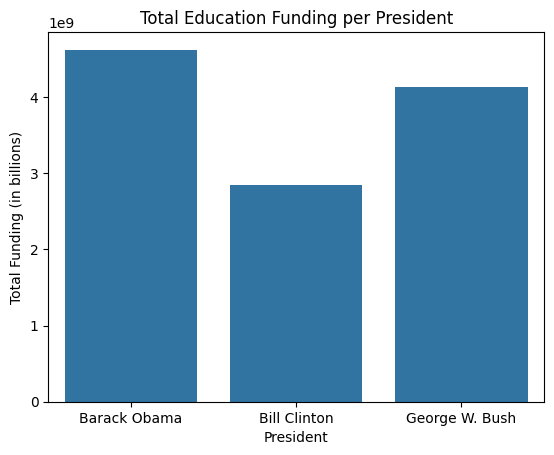

In [37]:
# Select the relevant columns from the DataFrame
df_p = df[['YEAR', 'TOTAL_REVENUE']]

# Filter the DataFrame to only include data from the years 1992 to 2016
df_p = df_p[df_p['YEAR'].between(1992, 2016)]

# Create a new column with the president's name based on the year
df_p['PRESIDENT'] = df_p['YEAR'].apply(lambda x: 'Bill Clinton' if 1993 <= x <= 2001 else ('George W. Bush' if 2001 <= x <= 2009 else 'Barack Obama'))

# Group the data by president and sum the total revenue
df_grouped = df_p.groupby('PRESIDENT')['TOTAL_REVENUE'].sum()

# Convert the resulting Series to a DataFrame
df_presidents = df_grouped.to_frame()

# Calculate the tenure of each president in years
df_presidents['TENURE'] = df_presidents.index.to_series().apply(lambda x: 8 if x == 'Bill Clinton' else (8 if x == 'George W. Bush' else 8))

# Set the president's names as the index of the DataFrame
df_presidents.index.name = 'PRESIDENT'

# Plot the total education funding per president as a bar chart
sns.barplot(data=df_presidents, x=df_presidents.index, y='TOTAL_REVENUE')

# Add a title and axis labels
plt.title('Total Education Funding per President')
plt.xlabel('President')
plt.ylabel('Total Funding (in billions)')

# Print the resulting DataFrame
print(df_presidents)

# Show the plot
plt.show()

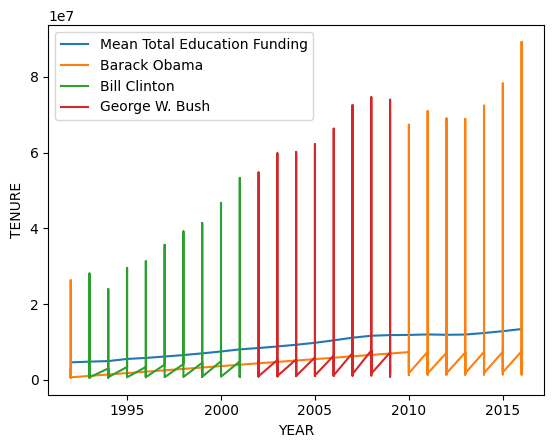

In [38]:
# Group the data by year and calculate the mean total education funding for each year
mean_by_year = df.groupby('YEAR')['TOTAL_REVENUE'].mean()

# Plot the mean total education funding by year
plt.plot(mean_by_year, label='Mean Total Education Funding')

# Plot the education funding of each president
for president, group in df_p.groupby('PRESIDENT'):
    plt.plot(group['YEAR'], group['TOTAL_REVENUE'], label=president)

# Add a legend and show the plot
plt.legend()
plt.xlabel('YEAR')
plt.ylabel('TENURE')
plt.show()

Text(0.5, 1.0, 'Distribution of INSTRUCTION_EXPENDITURE')

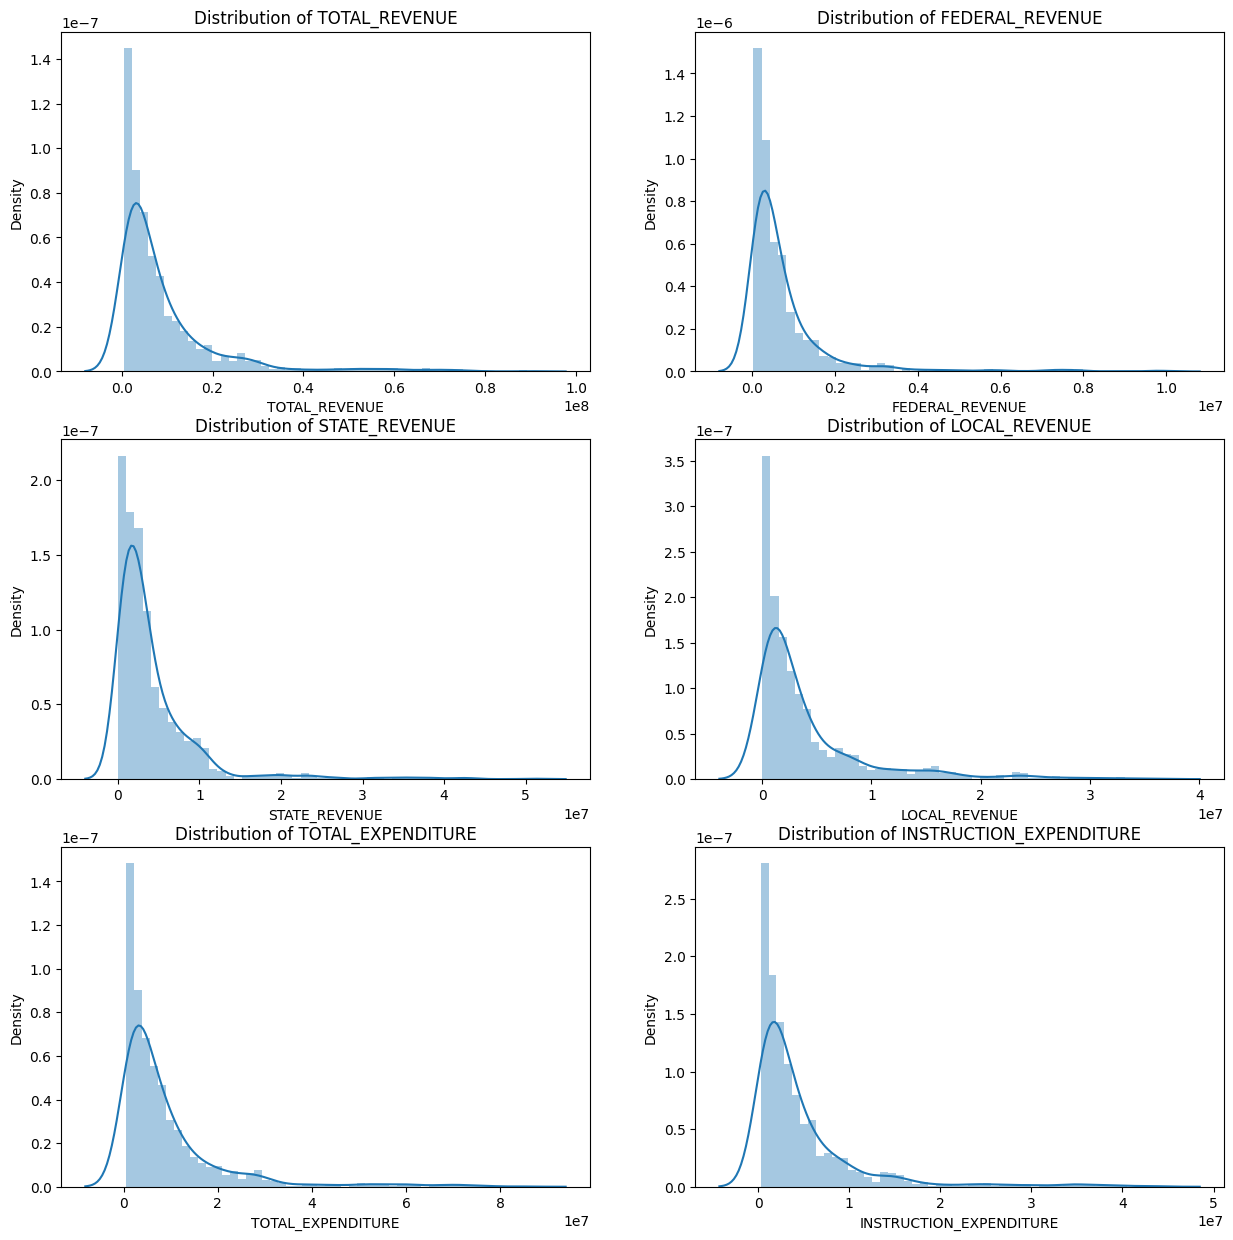

In [39]:
# Create a subplot with 3 rows and 2 columns
fig, ax = plt.subplots(3, 2, figsize=(15,15))

# Plot the distribution of TOTAL_REVENUE
sns.distplot(df['TOTAL_REVENUE'], ax=ax[0][0])
ax[0][0].set_title("Distribution of TOTAL_REVENUE")

# Plot the distribution of FEDERAL_REVENUE
sns.distplot(df['FEDERAL_REVENUE'], ax=ax[0][1])
ax[0][1].set_title("Distribution of FEDERAL_REVENUE")

# Plot the distribution of STATE_REVENUE
sns.distplot(df['STATE_REVENUE'], ax=ax[1][0])
ax[1][0].set_title("Distribution of STATE_REVENUE")

# Plot the distribution of LOCAL_REVENUE
sns.distplot(df['LOCAL_REVENUE'], ax=ax[1][1])
ax[1][1].set_title("Distribution of LOCAL_REVENUE")

# Plot the distribution of TOTAL_EXPENDITURE
sns.distplot(df['TOTAL_EXPENDITURE'], ax=ax[2][0])
ax[2][0].set_title("Distribution of TOTAL_EXPENDITURE")

# Plot the distribution of INSTRUCTION_EXPENDITURE
sns.distplot(df['INSTRUCTION_EXPENDITURE'], ax=ax[2][1])
ax[2][1].set_title("Distribution of INSTRUCTION_EXPENDITURE")

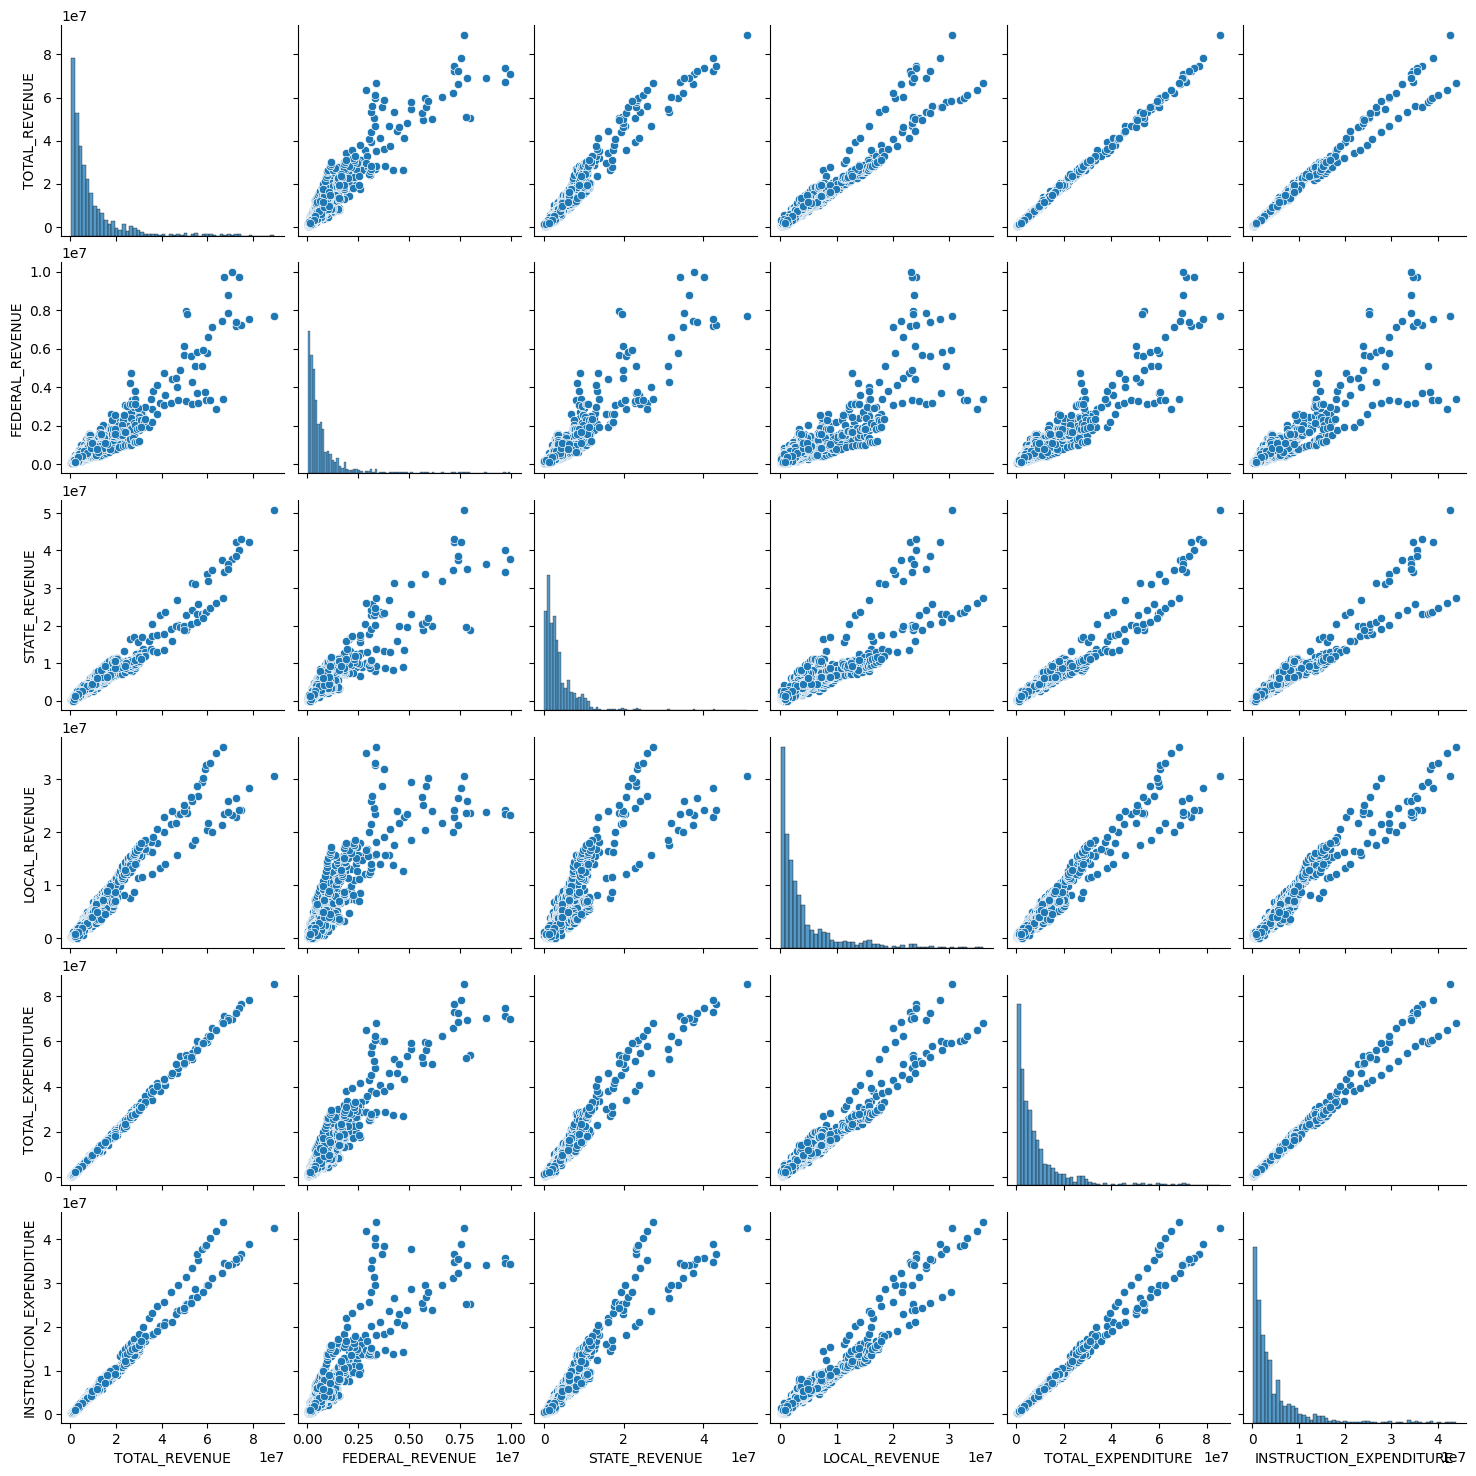

In [40]:
# Create a pairplot of the columns
sns.pairplot(df, vars=['TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE'])

      TOTAL_REVENUE  TOTAL_EXPENDITURE
YEAR                                  
1992      233210984          237333143
1993      243206654          244202408
1994      250750573          252664869
1995      279277709          281831835
1996      292952786          297740499
1997      311885259          315861220
1998      331730773          336384794
1999      354681711          360474429
2000      379602220          386177409
2001      408404990          417014891
2002      426548936          442685445
2003      447668013          462275098
2004      470489151          481241595
2005      496839635          506626625
2006      529971381          536742833
2007      565776634          569654941
2008      591836483          604581544
2009      600684313          616770225
2010      602881374          614739370
2011      609555659          607600935
2012      604716747          604805382
2013      608067328          608403723
2014      628641027          624718207
2015      653669669      

<Axes: xlabel='YEAR'>

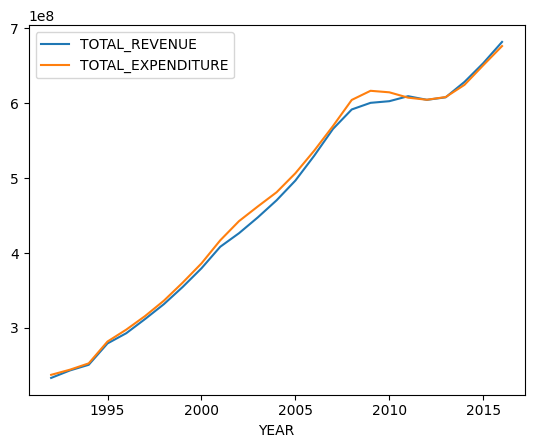

In [41]:
# Calculate total revenue and expenditure for each state
state_totals = df.groupby(['YEAR'])[['TOTAL_REVENUE', 'TOTAL_EXPENDITURE']].sum()

# Print the resulting DataFrame
print(state_totals)
state_totals.plot()

Text(0.5, 1.0, 'ENROLL and INSTRUCTION_EXPENDITURE')

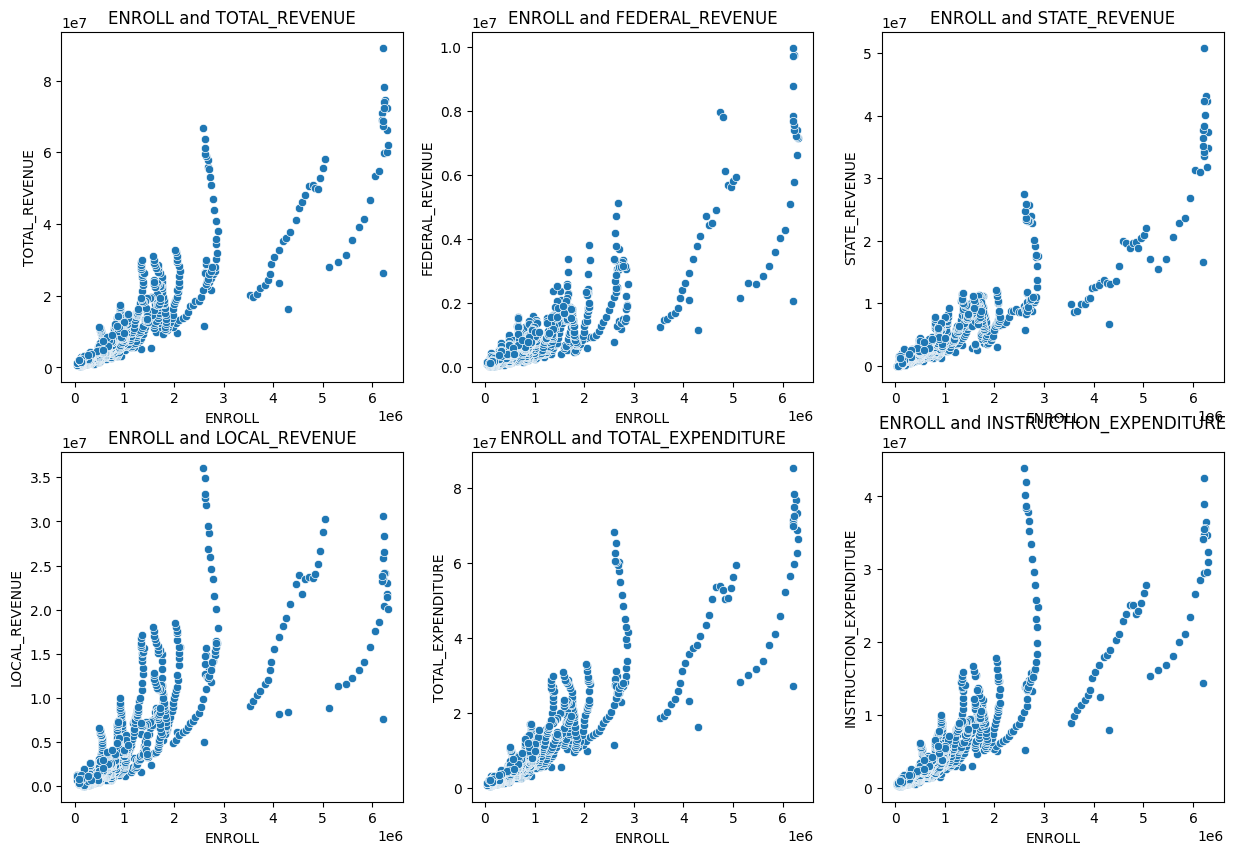

In [42]:
# Create a subplot with 2 rows and 3 columns
fig, ax = plt.subplots(2, 3, figsize=(15,10))

# Plot the relationship between ENROLL and TOTAL_REVENUE
sns.scatterplot(x="ENROLL", y="TOTAL_REVENUE", data=df, ax=ax[0][0])
ax[0][0].set_title("ENROLL and TOTAL_REVENUE")

# Plot the relationship between ENROLL and FEDERAL_REVENUE
sns.scatterplot(x="ENROLL", y="FEDERAL_REVENUE", data=df, ax=ax[0][1])
ax[0][1].set_title("ENROLL and FEDERAL_REVENUE")

# Plot the relationship between ENROLL and STATE_REVENUE
sns.scatterplot(x="ENROLL", y="STATE_REVENUE", data=df, ax=ax[0][2])
ax[0][2].set_title("ENROLL and STATE_REVENUE")

# Plot the relationship between ENROLL and LOCAL_REVENUE
sns.scatterplot(x="ENROLL", y="LOCAL_REVENUE", data=df, ax=ax[1][0])
ax[1][0].set_title("ENROLL and LOCAL_REVENUE")

# Plot the relationship between ENROLL and TOTAL_EXPENDITURE
sns.scatterplot(x="ENROLL", y="TOTAL_EXPENDITURE", data=df, ax=ax[1][1])
ax[1][1].set_title("ENROLL and TOTAL_EXPENDITURE")

# Plot the relationship between ENROLL and INSTRUCTION_EXPENDITURE
sns.scatterplot(x="ENROLL", y="INSTRUCTION_EXPENDITURE", data=df, ax=ax[1][2])
ax[1][2].set_title("ENROLL and INSTRUCTION_EXPENDITURE")

In [43]:
categoricals =['STATE']

In [44]:
for col in categoricals:
    df[col]=df[col].astype("category")

In [45]:
#separate 2 datasets

categoricals = pd.get_dummies(categoricals, columns=['state'])#, prefix = ['type'])
categoricals

,STATE
0,True


In [46]:
numerics     =['ENROLL','TOTAL_REVENUE','FEDERAL_REVENUE','STATE_REVENUE','LOCAL_REVENUE','TOTAL_EXPENDITURE','INSTRUCTION_EXPENDITURE','SUPPORT_SERVICES_EXPENDITURE','OTHER_EXPENDITURE','CAPITAL_OUTLAY_EXPENDITURE']

In [47]:
! pip install shap lime

In [48]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [49]:
!pip install pandas # Ensure pandas is installed if it isn't already.
# Import the necessary modules
import pandas as pd
from pandas.api.types import is_numeric_dtype # Import is_numeric_dtype

In [50]:
for col in df.columns:
    if is_numeric_dtype(df[col]):
        continue
    else:
        df[col]=le.fit_transform(df[col])
df.head()

,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
0,0,1992,736649.000,2678885,304177,1659028,715680,2653798,1481703,735036,451959.500,174053
1,1,1992,131178.000,1049591,106780,720711,222100,972488,498362,350902,55748.500,37451
2,2,1992,907901.000,3258079,297888,1369815,1590376,3401580,1435908,1007732,341430.500,609114
3,3,1992,459508.000,1711959,178571,958785,574603,1743022,964323,483488,191788.000,145212
4,4,1992,6205883.500,26260025,2072470,16546514,7641041,27138832,14358922,8520926,3090235.500,2044688


In [51]:
# Declare feature vector and target variable
x = df[['ENROLL','TOTAL_EXPENDITURE']]
y = df['TOTAL_REVENUE']

In [52]:
x.shape

(1275, 2)

In [53]:
len(y)

1275

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,train_size=0.75,random_state=42)

# Linear Regression

In [56]:
from sklearn.linear_model import LinearRegression
lereg=LinearRegression()

# KNN Regressor

In [57]:
from sklearn.neighbors import KNeighborsRegressor
knn=KNeighborsRegressor(n_neighbors=3)

# Random Forest Regression

In [58]:
from sklearn.ensemble import RandomForestRegressor
RFR=RandomForestRegressor()

# DecisionTreeRegressor

In [59]:
from sklearn.tree import DecisionTreeRegressor
dtree=DecisionTreeRegressor(max_depth=1)

# Support Vector Regression (SVR)

In [60]:
from sklearn.svm import SVR
svr_lr=SVR(C=1.0, epsilon=0.2, kernel='linear')
svr_rbf=SVR(kernel='rbf',C=1.0,epsilon=0.2)

# Lasso Regression

In [61]:
from sklearn import linear_model
lassoReg = linear_model.Lasso(alpha=0.1)

# Gradient Boosting

In [62]:
from sklearn.ensemble import GradientBoostingRegressor

In [63]:
GDboosing=GradientBoostingRegressor(n_estimators=500)

# Ada Boost

In [64]:
from sklearn.ensemble import AdaBoostRegressor

In [65]:
AdaBoost=AdaBoostRegressor(n_estimators=15,learning_rate=1.0)

# Extra Trees

In [66]:
from sklearn.ensemble import ExtraTreesRegressor

In [67]:
ExtraTree=ExtraTreesRegressor(n_estimators=100,
                              random_state=3,
                              max_samples=0.5,
                              max_features=0.75,
                              max_depth=15,
                            bootstrap=True)

# xgboost

In [68]:
from xgboost import XGBRegressor

In [69]:
XGB=XGBRegressor(n_estimators=45,max_depth=5,learning_rate=0.5)

# GaussianProcessRegressor

In [70]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel = DotProduct() + WhiteKernel()
gaussianReg = GaussianProcessRegressor(kernel=kernel,random_state=1)

# Voting Regressor

In [71]:
from sklearn.ensemble import VotingRegressor
rf = RandomForestRegressor(n_estimators=350,random_state=3,max_samples=0.5,max_features=0.75,max_depth=15)
gbdt = GradientBoostingRegressor(n_estimators=100,max_features=0.5)
xgb = XGBRegressor(n_estimators=25,learning_rate=0.3,max_depth=5)
et = ExtraTreesRegressor(n_estimators=100,random_state=3,max_samples=0.5,max_features=0.75,max_depth=10,bootstrap=True)
voting_reg = VotingRegressor([('rf', rf), ('gbdt', gbdt), ('xgb',xgb), ('et',et)],weights=[5,1,1,1])

In [72]:
def model(xtrain,ytrain,xtest,ytest):
    model_name=['LinearRegression','KNeighborsRegressor','RandomForestRegressor','DecisionTreeRegressor','SVR_linear','SVR_rbf','linear_model','GaussianProcessRegressor','GradientBoostingRegressor','AdaBoostRegressor','ExtraTreesRegressor','XGBRegressor','VotingRegressor']
    accuracy=[]
    #LinearRegression
    lereg.fit(xtrain,ytrain)
    accuracy.append(lereg.score(xtest,ytest))
    #KNeighborsRegressor
    knn.fit(xtrain,ytrain)
    accuracy.append(knn.score(xtest,ytest))
    #RandomForestRegressor
    RFR.fit(xtrain,ytrain)
    accuracy.append(RFR.score(xtest,ytest))
    #DecisionTreeRegressor
    dtree.fit(xtrain,ytrain)
    accuracy.append(dtree.score(xtest,ytest))
    #SVR_linear
    svr_lr.fit(xtrain,ytrain)
    accuracy.append(svr_lr.score(xtest,ytest))
    #SVR_rbf
    svr_rbf.fit(xtrain,ytrain)
    accuracy.append(svr_rbf.score(xtest,ytest))
    #linear_model
    lassoReg.fit(xtrain,ytrain)
    accuracy.append(lassoReg.score(xtest,ytest))
    #GaussianProcessRegressor
    gaussianReg.fit(xtrain,ytrain)
    accuracy.append(gaussianReg.score(xtest,ytest))
    #GradientBoostingRegressor
    GDboosing.fit(xtrain,ytrain)
    accuracy.append(GDboosing.score(xtest,ytest))
    #AdaBoostRegressor
    AdaBoost.fit(xtrain,ytrain)
    accuracy.append(AdaBoost.score(xtest,ytest))
    #ExtraTreesRegressor
    ExtraTree.fit(xtrain,ytrain)
    accuracy.append(ExtraTree.score(xtest,ytest))
    #XGBRegressor
    XGB.fit(xtrain,ytrain)
    accuracy.append(XGB.score(xtest,ytest))
    #VotingRegressor
    voting_reg.fit(xtrain,ytrain)
    accuracy.append(voting_reg.score(xtest,ytest))


    return model_name,accuracy

In [ ]:
%%time
model_name,wosamp_acc=model(xtrain,ytrain,xtest,ytest)

# Dataframe function

In [ ]:






def dataframe(y):
    vis={'Algorithm':['LinearRegression','KNeighborsRegressor','RandomForestRegressor','DecisionTreeRegressor','SVR_linear','SVR_rbf','linear_model','GaussianProcessRegressor','GradientBoostingRegressor','AdaBoostRegressor','ExtraTreesRegressor','XGBRegressor','VotingRegressor'],
     'Accuracy':y

    }
    accuracy=pd.DataFrame(vis)
    return accuracy

In [ ]:
final_df=pd.DataFrame({
    'Algorithm':['LinearRegression','KNeighborsRegressor','RandomForestRegressor','DecisionTreeRegressor','SVR_linear','SVR_rbf','linear_model','GaussianProcessRegressor','GradientBoostingRegressor','AdaBoostRegressor','ExtraTreesRegressor','XGBRegressor','VotingRegressor']

})

In [ ]:
final_df

In [ ]:
wosamp_acc

In [ ]:
final_df['Accuracy']=wosamp_acc
final_df

In [ ]:
acc_df1=dataframe(wosamp_acc)
acc_df1

In [ ]:
plt.figure(figsize=(16,8))
sns.set()
plt.title('Accuracy Comparison')
sns.barplot(y="Algorithm",x='Accuracy',data=acc_df1,palette='Set2')
sns.set(rc={'figure.figsize':(15,5)})

NB: Linear Regression is the best Algorithm for this Dataset.

In [ ]:
! pip install shap

In [ ]:
# import shap library
import shap                                                       # SHAP values >> contributions of each feature to a model's prediction for a single instance of data

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(RFR)
shap_values = explainer.shap_values(xtrain)                                      # numpy array containing the SHAP values calculated for the entire training dataset


# visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], xtrain.iloc[0,:])
# expected_value = represents the base value which is the average model output over the training dataset
# shap_values[0,:]=  extracts the SHAP values for the first row of the data
# X_train.iloc[0,:]= first row of the DataFrame

In [ ]:
# using matplotlib to make a white background for clear visualization----
import matplotlib.pyplot as plt

# Visualize the first prediction's explanation with a white background
plt.figure(figsize=(10, 4))  # Adjust figure size as needed
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], xtrain.iloc[0,:], matplotlib=True, show=False)
plt.gca().set_facecolor('white')  # Set background color to white
plt.show()

In [ ]:
# using matplotlib to make a white background for clear visualization----
import matplotlib.pyplot as plt

# Visualize the first prediction's explanation with a white background
plt.figure(figsize=(10, 4))  # Adjust figure size as needed
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], xtrain.iloc[0,:], matplotlib=True, show=False)
plt.gca().set_facecolor('white')  # Set background color to white
plt.show()

In [ ]:
shap_values = shap.TreeExplainer(RFR).shap_values(xtrain)
shap.summary_plot(shap_values, xtrain, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, xtrain)

In [ ]:
# import shap library
import shap                                                       # SHAP values >> contributions of each feature to a model's prediction for a single instance of data

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(XGB)
shap_values = explainer.shap_values(xtrain)                                      # numpy array containing the SHAP values calculated for the entire training dataset


# visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], xtrain.iloc[0,:])
# expected_value = represents the base value which is the average model output over the training dataset
# shap_values[0,:]=  extracts the SHAP values for the first row of the data
# X_train.iloc[0,:]= first row of the DataFrame